In [1]:
from PIL import Image
import os

# Создайте списки для хранения фотографий и соответствующих им меток классов
images = []
labels = []
features = []

# Путь к директории с фотографиями
dataset_dir = "C:\\Users\\extre\\Downloads\\test"

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                # Загрузите изображение и добавьте его в список
                file_path = os.path.join(class_dir, filename)
                image_data = Image.open(file_path)
                images.append(image_data)
                
                # Присвойте метку класса на основе названия директории
                if class_name == "muffin":
                    labels.append("muffin")
                elif class_name == "chihuahua":
                    labels.append("chihuahua")


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Загрузите предварительно обученную модель VGG16 без верхних слоев
model = VGG16(weights='imagenet', include_top=False)

def extract_features(img):
    # Преобразуйте изображение в нужный размер и формат
    img = img.convert("RGB").resize((224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    features = model.predict(img_data)
    return features.flatten()

# Извлеките признаки для всех изображений
features_list = [extract_features(img) for img in images]


1/1 [==============================] - 1s 1s/step


In [5]:
data = {
    'image': images, 
    'label': labels,
    'features': features_list
}
dataset = pd.DataFrame(data)

In [6]:
dataset.head()

,image,label,features
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,chihuahua,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.3338532, 0.0,..."
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,chihuahua,"[0.0, 0.0, 0.0, 0.0, 34.896317, 9.191946, 0.0,..."
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,chihuahua,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,chihuahua,"[13.256821, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,chihuahua,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.162128, ..."


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     1184 non-null   object
 1   label     1184 non-null   object
 2   features  1184 non-null   object
dtypes: object(3)
memory usage: 27.9+ KB


In [8]:
dataset.isnull().sum()

image       0
label       0
features    0
dtype: int64

In [9]:
X = np.array(features_list)

In [10]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

C:\Users\extre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\extre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\extre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\extre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

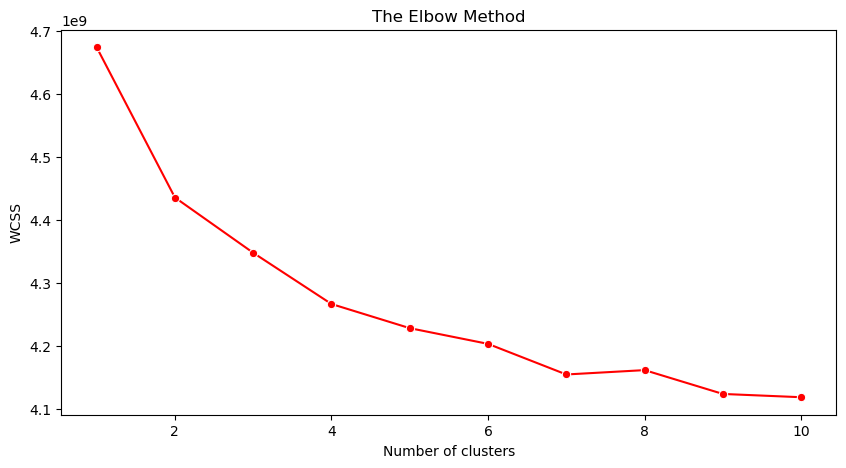

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(x=range(1, 11), y=wcss, marker='o', color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(np.array(features_list, dtype=np.float64))

C:\Users\extre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\extre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [38]:
import pickle

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [35]:
def predict_single_image(img_path):
    # Загрузите изображение
    img = Image.open(img_path)
    
    # Извлеките признаки из изображения
    img = img.convert("RGB").resize((224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    features = model.predict(img_data).flatten().astype(np.float64)
    
    # Используйте kmeans для предсказания
    prediction = kmeans.predict([features])
    
    # Верните метку класса на основе предсказания
    if prediction[0] == 1:
        return "muffin"
    else:
        return "chihuahua"


In [37]:
img_path = "C:\\Users\\extre\\Downloads\\traing.jpg"
print(f"Predicted label: {predict_single_image(img_path)}")

1/1 [==============================] - 1s 1s/step
Predicted label: chihuahua
